# Hidden Markov Model

In [1]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn import set_config
import itertools
import warnings
import warnings
import logging

In [3]:
# attempt to make warnings and output messages invisible
set_config(display="text")
warnings.filterwarnings("ignore")
logging.getLogger("hmmlearn").setLevel(logging.ERROR)

In [4]:
drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/semester_project_2.3/afdb_train_scaled.csv"
test_path  = "/content/drive/MyDrive/semester_project_2.3/afdb_test_scaled.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

Mounted at /content/drive


#### If any columns are empty, we fill them with the mean and then we remove the 'label' column

In [5]:
# fill empty columns with mean
train = train.fillna(train.mean())
test  = test.fillna(test.mean())

# remove labels from train/test sets
if 'label' in train.columns:
    # store labels before removing them
    train_labels = train['label'].values
    true_labels = test['label'].values

    # separate features from labels
    feature_columns = [col for col in train.columns if col != 'label']
    train_obs = train[feature_columns].values
    test_obs = test[feature_columns].values

else:
    train_obs = train.values
    test_obs = test.values
    train_labels = None
    true_labels = None

#### Let's see how a simple HMM does

In [6]:
# define, fit and test a simple HMM

n_states = 4 # hidden states
hmm_model = GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=50
)

_ = hmm_model.fit(train_obs) # syntax is like that so nothing gets printed

#### Log probabilities tell us how well the model can explain the observed test data

In [7]:
# measures how well the model explains the observed test data
log_prob = hmm_model.score(test_obs)
print("Log-likelihood of test data:", log_prob)

# decode the most likely hidden states for test data
hidden_states = hmm_model.predict(test_obs)
print("First 20 hidden states:", hidden_states[:20])

Log-likelihood of test data: 74240.37381218366
First 20 hidden states: [0 0 0 2 2 2 2 2 2 0 2 2 2 2 0 0 0 0 0 2]


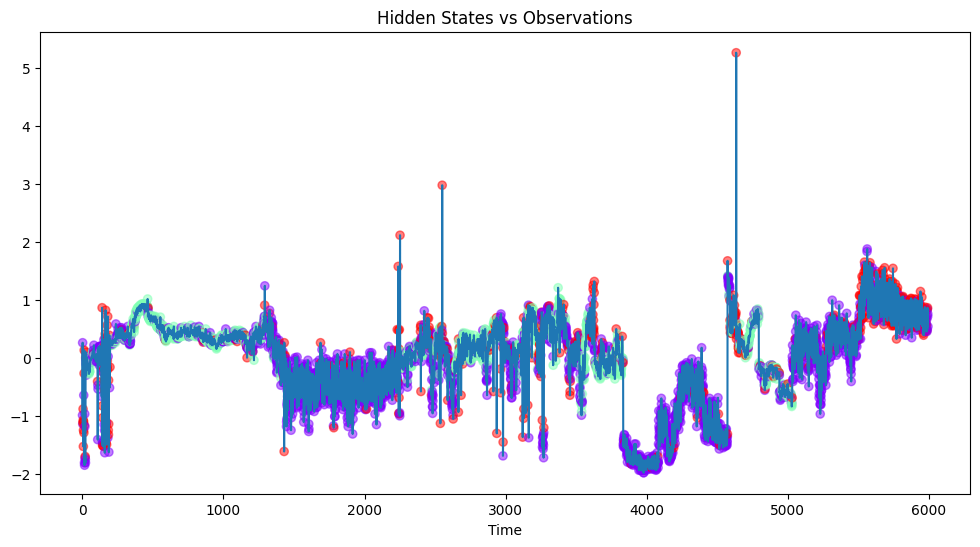

In [8]:
# plot observations vs hidden states
# the colors "hugging" the signal showcase which
# hidden state was assigned to each observation

plt.figure(figsize=(12,6))
plt.plot(test_obs[:, 1], label="Feature 0")
plt.scatter(
    range(len(hidden_states)),
    test_obs[:, 1],
    c=hidden_states,
    cmap="rainbow",
    label="Hidden states",
    alpha=0.5
)
plt.title("Hidden States vs Observations")
plt.xlabel("Time")
plt.show()

Test Accuracy: 73.25%

Classification Report:

               precision    recall  f1-score   support

      Normal       1.00      0.54      0.70      3497
        AFib       0.61      1.00      0.76      2500

    accuracy                           0.73      5997
   macro avg       0.80      0.77      0.73      5997
weighted avg       0.84      0.73      0.73      5997





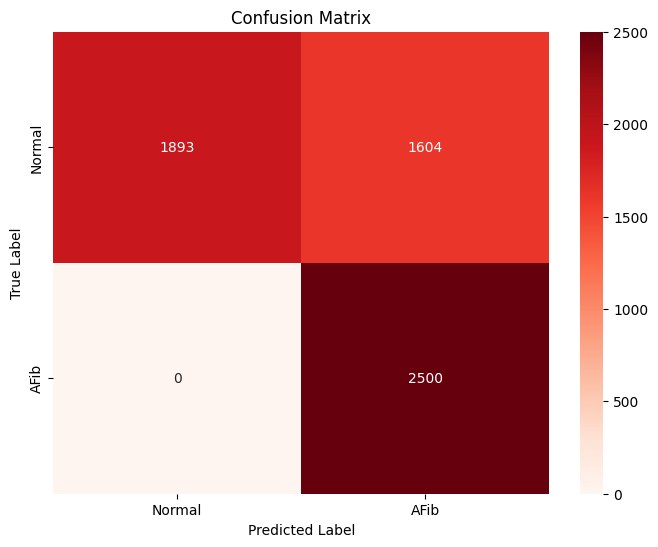

In [9]:
# map hidden states to majority labels
train_hidden_states = hmm_model.predict(train_obs)

# use the existing train_labels variable from the preprocessing cell
state_to_label = {
    state: np.bincount(train_labels[train_hidden_states == state]).argmax()
    if np.any(train_hidden_states == state) else 0
    for state in range(n_states)
}

# predicted labels
test_hidden_states = hmm_model.predict(test_obs)
pred_labels = np.array([state_to_label[s] for s in test_hidden_states])

# accuracy
acc = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {acc*100:.2f}%\n")

# classification report
print("Classification Report:\n\n", classification_report(true_labels, pred_labels, target_names=['Normal', 'AFib']))
print("\n")

# confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=['Normal', 'AFib'], columns=['Normal', 'AFib'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Reds')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## Grid Search
Let's perform a grid search for the different parameters on an HMM, namely, amount of hidden states, covariance type, and iterations

In [10]:
# grid search params
n_states_list = [2, 3, 5, 7, 10]
cov_types     = ['full', 'diag']
n_iters       = [25, 50, 100, 200]

# best configuration metrics and params
best_acc = 0
best_config = {}

# all results (for inspection)
results = []

# -----------
# grid search
# -----------
for n_states, cov, n_iter in itertools.product(n_states_list, cov_types, n_iters):
    hmm_model = GaussianHMM(
        n_components=n_states,
        covariance_type=cov,
        n_iter=n_iter,
        random_state=42
    )
    _ = hmm_model.fit(train_obs)

    # predict hidden states on test set
    train_hidden_states = hmm_model.predict(train_obs)

    # map hidden states to majority labels
    state_to_label = {
      state: np.bincount(train_labels[train_hidden_states == state]).argmax()
      if np.any(train_hidden_states == state) else 0
      for state in range(n_states)
    }

    # convert hidden states to predicted labels
    test_hidden_states = hmm_model.predict(test_obs)
    pred_labels = np.array([state_to_label[s] for s in test_hidden_states])

    # compute metrics
    acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    # save results
    results.append({
        'n_states': n_states,
        'cov_type': cov,
        'n_iter': n_iter,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    # track best
    if acc > best_acc:
        best_acc = acc
        best_config = {
            'n_states': n_states,
            'cov_type': cov,
            'n_iter': n_iter,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'pred_labels': pred_labels.copy()
        }

    print(f"Just completed\nParameters: n={n_states}, cov={cov}, iter={n_iter}\n"
        f"Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}\n")

# convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df

Just completed
Parameters: n=2, cov=full, iter=25
Accuracy=0.7390, Precision=0.6150, Recall=1.0000, F1=0.7616

Just completed
Parameters: n=2, cov=full, iter=50
Accuracy=0.7390, Precision=0.6150, Recall=1.0000, F1=0.7616

Just completed
Parameters: n=2, cov=full, iter=100
Accuracy=0.7390, Precision=0.6150, Recall=1.0000, F1=0.7616

Just completed
Parameters: n=2, cov=full, iter=200
Accuracy=0.7390, Precision=0.6150, Recall=1.0000, F1=0.7616

Just completed
Parameters: n=2, cov=diag, iter=25
Accuracy=0.8468, Precision=0.7417, Recall=0.9704, F1=0.8408

Just completed
Parameters: n=2, cov=diag, iter=50
Accuracy=0.7681, Precision=0.6425, Recall=1.0000, F1=0.7824

Just completed
Parameters: n=2, cov=diag, iter=100
Accuracy=0.7681, Precision=0.6425, Recall=1.0000, F1=0.7824

Just completed
Parameters: n=2, cov=diag, iter=200
Accuracy=0.7681, Precision=0.6425, Recall=1.0000, F1=0.7824

Just completed
Parameters: n=3, cov=full, iter=25
Accuracy=0.6296, Precision=0.5714, Recall=0.4468, F1=0.501

,n_states,cov_type,n_iter,accuracy,precision,recall,f1_score
0,2,full,25,0.739036,0.615006,1.0000,0.761615
1,2,full,50,0.739036,0.615006,1.0000,0.761615
2,2,full,100,0.739036,0.615006,1.0000,0.761615
3,2,full,200,0.739036,0.615006,1.0000,0.761615
4,2,diag,25,0.846757,0.741669,0.9704,0.840756
5,2,diag,50,0.768051,0.642508,1.0000,0.782350
6,2,diag,100,0.768051,0.642508,1.0000,0.782350
7,2,diag,200,0.768051,0.642508,1.0000,0.782350
8,3,full,25,0.629648,0.571355,0.4468,0.501459
9,3,full,50,0.629648,0.571355,0.4468,0.501459


Optimal Configuration
n=10, iterations=100, cov:full

Accuracy: 94.61%
Precision: 0.9191
Recall: 0.9548
F1-score: 0.9366


Classification Report for optimal HMM configuration:

              precision    recall  f1-score   support

      Normal       0.97      0.94      0.95      3497
        AFib       0.92      0.95      0.94      2500

    accuracy                           0.95      5997
   macro avg       0.94      0.95      0.94      5997
weighted avg       0.95      0.95      0.95      5997





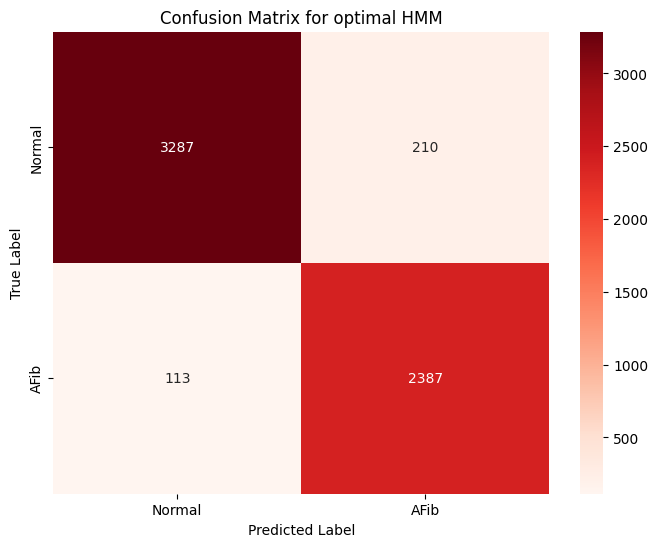

In [11]:
# summarize best result
print("Optimal Configuration")
print(f"n={best_config['n_states']}, iterations={best_config['n_iter']}, cov:{best_config['cov_type']}\n")
print(f"Accuracy: {best_config['accuracy']*100:.2f}%")
print(f"Precision: {best_config['precision']:.4f}")
print(f"Recall: {best_config['recall']:.4f}")
print(f"F1-score: {best_config['f1_score']:.4f}\n")

# classification report
best_pred_labels = best_config['pred_labels']
print("\nClassification Report for optimal HMM configuration:\n")
print(classification_report(true_labels, best_pred_labels, target_names=['Normal', 'AFib']))
print("\n")

# confusion matrix
cm = confusion_matrix(true_labels, best_pred_labels)
cm_df = pd.DataFrame(cm, index=['Normal', 'AFib'], columns=['Normal', 'AFib'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Reds')
plt.title(f"Confusion Matrix for optimal HMM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()